In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.datasets as datasets

## 0.前言
>基于a04.10修改，保持原有的说明

目标：实现如下网络

$$\mathrm{out}=\mathrm{ReLU}_3(\mathrm{ReLU}_2\lgroup\mathrm{ReLU}_1(X@W_1+b_1)@W_2+b_2\rgroup@W_3+b_3)$$

数据集：MNIST
输入节点数为784，第一层输出节点为256，第二层输出节点为128，第三层输出节点为10


## 1.加载数据
将shape为\[b,28,28\] -> \[b,28*28\]

In [3]:
def preprocess(x,y):
    # 调用此函数会自动传入x，y
    # 标准化到0~1
    x=tf.cast(x,dtype=tf.float32)/255.
    x=tf.reshape(x,[-1,28*28]) # 打平
    y=tf.cast(y,dtype=tf.int32) # 转换成整型张量
    y=tf.one_hot(y,depth=10) # 进行one-hot编码
    return x,y

def load_data():
    # 加载MNIST
    (x,y),(x_val,y_val)=datasets.mnist.load_data()
    batchsz=512
    # 构建数据集对象
    train_dataset=tf.data.Dataset.from_tensor_slices((x,y))
    train_dataset=train_dataset.shuffle(1000)
    #批量训练
    train_dataset=train_dataset.batch(batchsz)
    train_dataset=train_dataset.map(preprocess)
    train_dataset=train_dataset.repeat(20)

    # 加载验证/测试集
    val_dataset=tf.data.Dataset.from_tensor_slices((x_val,y_val))
    val_dataset=val_dataset.shuffle(1000).batch(batchsz).map(preprocess)
    return train_dataset,val_dataset


## 2.创建并初始化非线性层的张量参数

> `tf.random.truncated_normal`从截断的正态分布中输出随机值。 生成的值服从具有指定平均值和标准偏差的正态分布，如果生成的值大于平均值2个标准偏差的值则丢弃重新选择。

In [4]:
def init_paramaters():
    # 每个张量需要被优化，所以使用tf.Variable
    # 第一层
    W1=tf.Variable(tf.random.truncated_normal([784,256],stddev=.1))
    b1=tf.Variable(tf.zeros([256]))

    # 第二层
    W2=tf.Variable(tf.random.truncated_normal([256,128],stddev=.1))
    b2=tf.Variable(tf.zeros([128]))

    # 输出层
    W3=tf.Variable(tf.random.truncated_normal([128,10],stddev=.1))
    b3=tf.Variable(tf.zeros([10]))

    return W1,b1,W2,b2,W3,b3

## 3.前向

In [5]:
def my_forward(x,W1,b1,W2,b2,W3,b3):
    # 第一层计算，bx784 @ 784x256 + 256 => bx256 + 256 => bx256 + bx256
    h1=x@W1+tf.broadcast_to(b1,[x.shape[0],256])
    h1=tf.nn.relu(h1) # 激活函数处理

    # 第二层计算，bx256 @ 256x128 + 128 => bx128 + 128 => bx128 + bx128
    h2=h1@W2+b2
    h2=tf.nn.relu(h2) # 激活函数处理

    # 输出层计算，bx128 @ 128x10 + 10 => bx10 + 10 => bx10 + bx10
    out=h2@W3+b3

    return out

## 4.误差计算

In [6]:
def mse_loss(y,p):
    # mse = mean(sum(y-p)^2)
    loss=tf.square(y-p)
    loss=tf.reduce_mean(loss)
    return loss

## 5.求梯度

In [7]:
# 全局变量
losses=list()
accs=list()

def train_epoch(train_dataset,val_dataset,W1,b1,W2,b2,W3,b3,epoch,lr=0.001):
    for step,(x,y) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            out=my_forward(x,W1,b1,W2,b2,W3,b3)
            loss=mse_loss(y,out)

        # 自动梯度，需要求梯度的张量有[W1,b1,W2,b2,W3,b3]
        grads=tape.gradient(loss,[W1,b1,W2,b2,W3,b3])
        # 梯度更新，assign_sub将当前值减去参数值（原地更新）
        for p,g in zip([W1,b1,W2,b2,W3,b3],grads):
            p.assign_sub(lr*g)
        if step % 80 == 0:
            print(f'epoch[{epoch}],step[{step}],loss: {float(loss)}')
            global losses
            losses.append(float(loss))
        # 进行验证
        if step % 80 ==0:
            # evaluate/test
            total, total_correct = 0., 0
            for x,y in val_dataset:
                out=my_forward(x,W1,b1,W2,b2,W3,b3)
                pred=tf.argmax(out,axis=1) # 寻找每个样本的最大得分类别
                num_y=tf.argmax(y,axis=1) # 将one-hot转为数字
                correct=tf.equal(pred,num_y)
                # bool -> int -> numpy
                total_correct+=tf.reduce_sum(tf.cast(correct,dtype=tf.int32)).numpy()
                total+=x.shape[0]

            print(f'epoch[{epoch}],step[{step}],acc: {total_correct/total}')
            global accs
            accs.append(total_correct/total)
    return loss.numpy()

def run(epochs):
    losses=[]
    train_dataset,val_dataset=load_data()
    W1,b1,W2,b2,W3,b3=init_paramaters()
    for epoch in range(epochs):
        loss=train_epoch(train_dataset,val_dataset,W1,b1,W2,b2,W3,b3,epoch=epoch,lr=0.001)
        # print(f'epoch[{epoch}]-loss: {loss}')
        # losses.append((loss))
    # 绘制曲线
    # xx=[i for i in range(0,epochs)]
    # plt.plot(xx,losses,color='b',marker='s',label='训练')
    # plt.xlabel('Epoch')
    # plt.ylabel('MSE')
    # plt.legend()
    # plt.show()

In [8]:
run(epochs=20)

epoch[0],step[0],loss: 0.4920617640018463
epoch[0],step[0],acc: 0.1019
epoch[0],step[80],loss: 0.25157657265663147
epoch[0],step[80],acc: 0.1112
epoch[0],step[160],loss: 0.21167269349098206
epoch[0],step[160],acc: 0.1105
epoch[0],step[240],loss: 0.1925976723432541
epoch[0],step[240],acc: 0.1112
epoch[0],step[320],loss: 0.1719084531068802
epoch[0],step[320],acc: 0.1148
epoch[0],step[400],loss: 0.1731727570295334
epoch[0],step[400],acc: 0.1209
epoch[0],step[480],loss: 0.16877774894237518
epoch[0],step[480],acc: 0.1271
epoch[0],step[560],loss: 0.1597992330789566
epoch[0],step[560],acc: 0.1351
epoch[0],step[640],loss: 0.1479456126689911
epoch[0],step[640],acc: 0.1437
epoch[0],step[720],loss: 0.14450275897979736
epoch[0],step[720],acc: 0.1525
epoch[0],step[800],loss: 0.14568746089935303
epoch[0],step[800],acc: 0.1611
epoch[0],step[880],loss: 0.1453542411327362
epoch[0],step[880],acc: 0.1688
epoch[0],step[960],loss: 0.13847655057907104
epoch[0],step[960],acc: 0.1782
epoch[0],step[1040],loss:

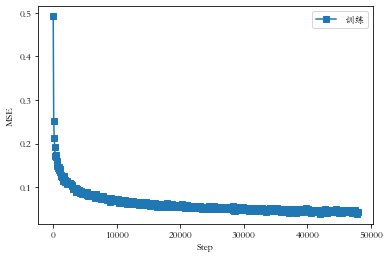

In [9]:
plt.figure()
x=[i*80 for i in range(len(losses))]
plt.plot(x,losses,color='C0',marker='s',label='训练')
plt.ylabel('MSE')
plt.xlabel('Step')
plt.legend()
plt.show()

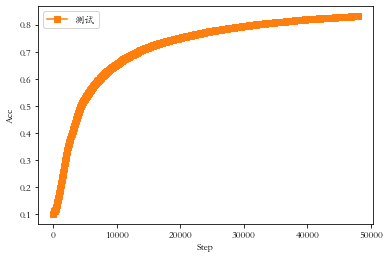

In [10]:
plt.figure()
plt.plot(x,accs,color='C1',marker='s',label='测试')
plt.ylabel('Acc')
plt.xlabel('Step')
plt.legend()
plt.show()



In [ ]:
import os
pid=os.getpid()
!kill -9 $pid